# A Simple Stack in molsim

Below, I've annotated this document to let you know what's happening in every step.  If you really want to do a quick and dirty stack, using our GOTHAM DR2 data and any arbitrary spcat catalog, you need only change 3 items and then just run the code from top to bottom.

1. Replace the filepath as discussed immediately following these instructions in the ipython_quickstart.py file and in the first line of actual code.  You only have to do this once, as long as you don't move the `molsim` folder around on your system.

2. Change the path in the `load_obs` command to wherever you put the `gotham_dr2.npz` file in your system.

3. Change the path in the `load_mol` command to point to the SPCAT catalog you want to stack.

Then just hit the double right arrows in the Jupyter Notebook control panel.  It will execute the entire script and produce the plots for you.  

Indeed, after you've done steps 1 and 2 once, just save this notebook.  Then, anytime you want to try stacking a new molecule, you literally need only do step 3, and change the catalog you're using for the stack!

If you want to do a little customization, or understand a bit of what's going on, I've documented it a bit below.  

Please note this is not meant to be a highly customized or flexible script.  It's supposed to do a quick and dirty stack for you.

First, load in all the various functions from molsim.  You will need to open the `ipython_quickstart.py` file in the main molsim folder and replace `/Users/Brett/Dropbox/Programs` with the path to where you placed the molsim older.  You only have to do this once unless you move the folder.

Then, run that file using the command below.  Be sure to replace `/Users/Brett/Dropbox/Programs/molsim/ipython_quickstart.py` with the actual path to the `ipython_quickstart.py` file on your system.

In [1]:
%run -i /Users/Brett/Dropbox/Programs/molsim/ipython_quickstart.py

The next line tells matplotlib that we're running in a Jupyter Notebook and to let us have interactivity like zooming.

In [2]:
%matplotlib notebook

Now we load the GOTHAM DR2 data in to the variable tmc1.  This is a helper function which generates an `Observation` class object that can contain information on the observatory (in an `Observatory` object) and the observed spectrum itself in a `Spectrum` object.  Be sure to change the path to wherever you put the `gotham_dr2.npz` file in your system.

In [5]:
tmc1 = load_obs('/Users/Brett/Dropbox/TMC1/gotham_dr2.npz')

Because you loaded in the data from a molsim-formatted file, using this helper function, molsim knows to read in information I stored in the file about the GBT, most importantly the dish size (100 m).  You can inspect this by typing `tmc1.observatory.dish`

Next, we want to load in a catalog file and store it inside a `Molecule` object.  Again, there is a helper function.  If you're using a molsim formatted catalog, just provide the path to that file.  If you're using an SPCAT formatted file, you also need to specify `type = 'spcat'` as an additional option.  Note that `load_mol` also allows you to specify a file that contains partition function information, but that's not necessary for a quick stack of a molecule.

In [38]:
my_mol = load_mol('/Users/Brett/Dropbox/Publications/GOTHAM-ARKHAM/GOTHAM/gotham_catalogs/2-cyano-CPD.cat',type='spcat')

Next, we want to find the limits of our observational data so that we don't waste resources simulating lines where we don't have observations.  We do that with the `find_limits` helper function, that returns a lower limit and an upper limit, in that order, given a frequency array.

In [39]:
ll0,ul0 = find_limits(tmc1.spectrum.frequency)

Now we need to specify things about our actual source that we're simulating, like the size on the sky in arcseconds, the vlsr, linewidth, excitation temperature, and column density.  Note that for many catalogs, the column density won't be accurate as the partition function that is calculated automatically isn't very accurate.  molsim does the best it can for partition functions based on incomplete information, but it's not perfect.  

Here, we are directly creating a `Source` object.

In [40]:
my_source = Source(size=30,dV=0.3,velocity=5.8,Tex=6,column=1E13)

Now, we need to actually run a simulation and make a spectrum.  We do that by creating a `Simulation` object, and passing it information.  We specify the molecule (`mol`), the limits (`ll` and `ul`), the `observation`, the `source`, what kind of `line_profile` we want to use (right now, the only option is Gaussian), and the resolution (`res`) we want our simulation to have, in MHz.

In [41]:
sim = Simulation(mol=my_mol,ll=ll0,ul=ul0,observation=tmc1,source=my_source,line_profile='Gaussian',res=0.0014)

You can inspect the simulation by overplotting it on top of the observations.  The `plot_sim` command takes a single required argument, the Simulation object you want to plot.  It takes a host of additional parameters to customize the plot, in the form of a dictionary.  For now, all we need is to say we also want to plot an observation (`obs`) and pass it that.  Note that both the required Simulation and the Observation must be in lists (`[]`) even if there's only one, since `plot_sim` is very flexible and will plot as many things as you give it.

<IPython.core.display.Javascript object>


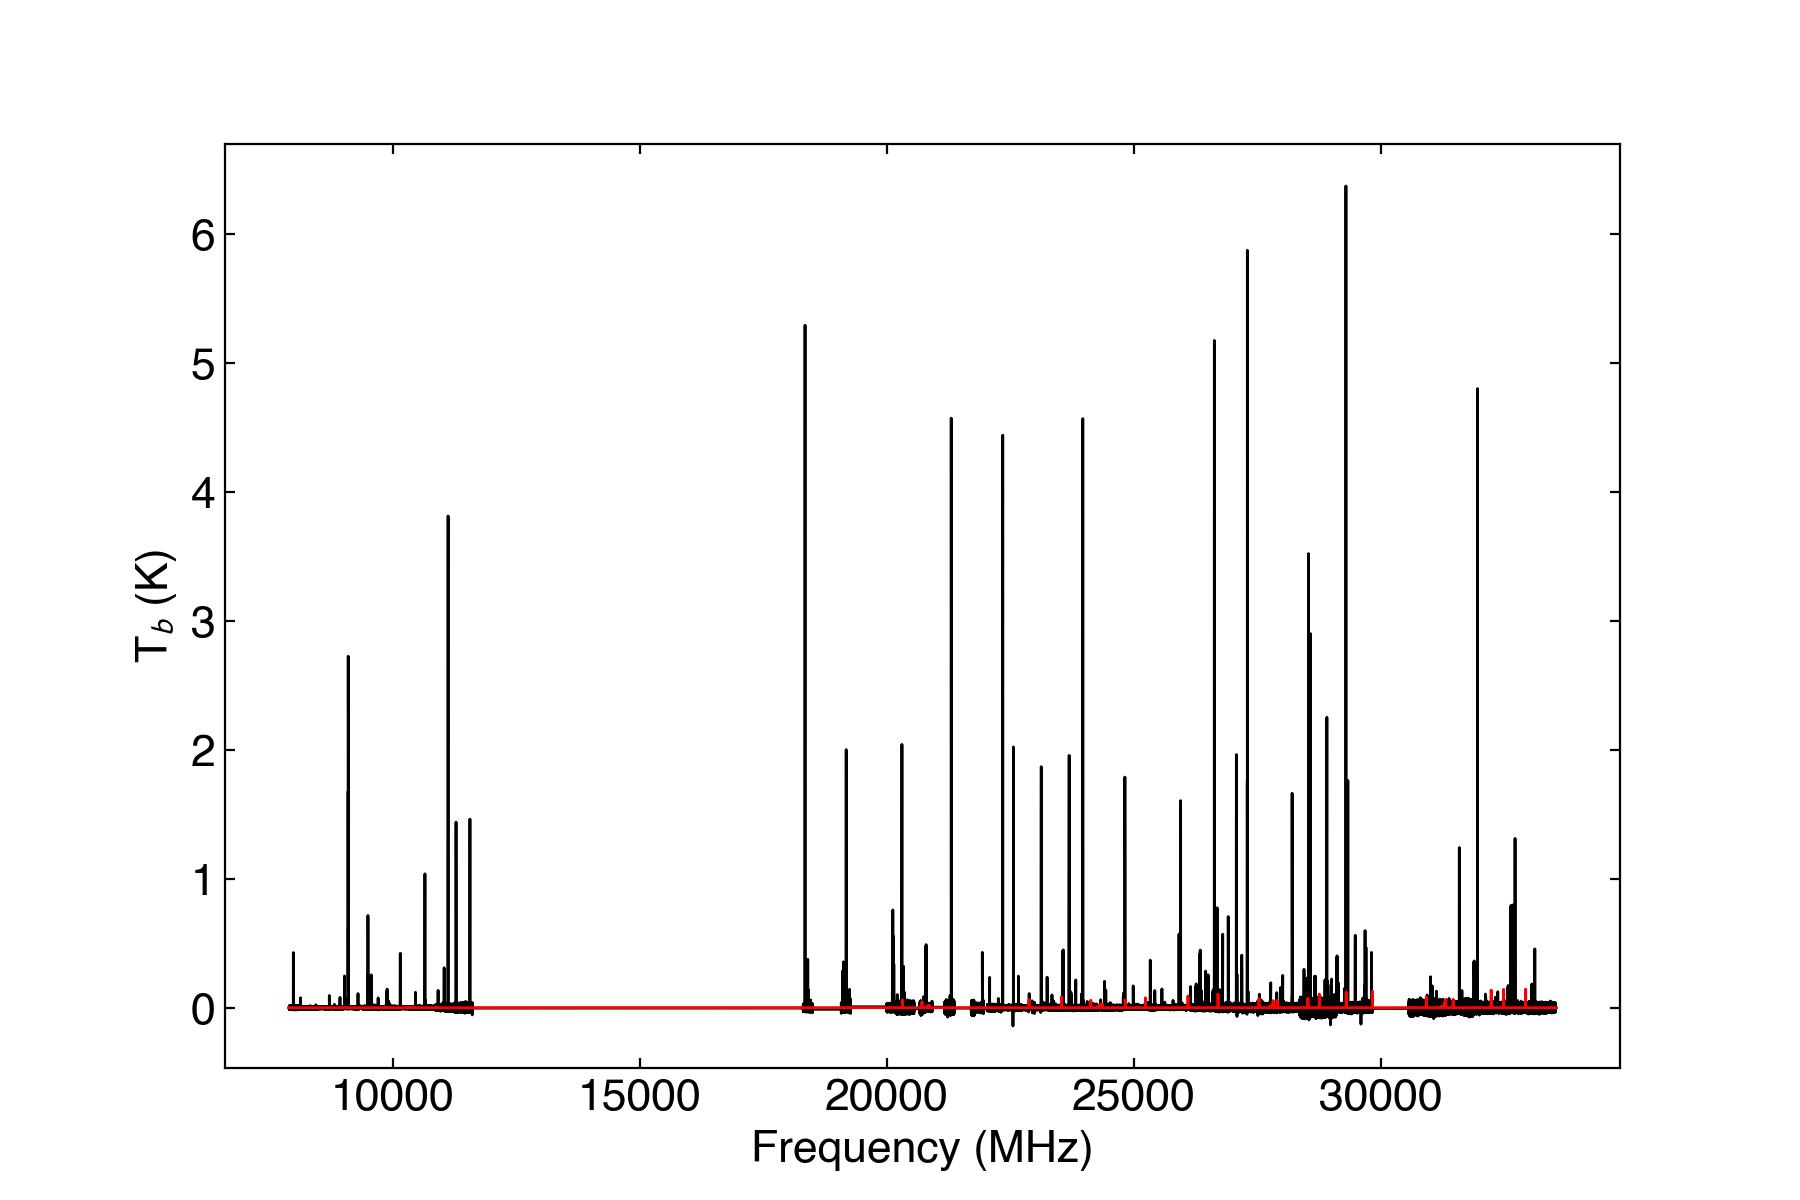

In [42]:
plot_sim([sim.spectrum],params={'obs': [tmc1.spectrum]})

Now we'll actually perform a stack on the data.  Stacking is done with the `velocity_stack` command, that takes a single argument, which is a dictionary that has a ton of options in it.  Below, I've made a simple dictionary that contains the options that produce a good stack for molecules in our TMC-1 data.  Note this treats the signal as a single velocity component.  There's a chance a full MCMC fit (coming "soon") will produce a better result, but this gets us 90% of the way there for most species.

I've added some comments in the dictionary to give you a clue as to what each option does, but it's safe to just ignore everything and use as a black box if you want.  Note that it can get a little tricky when to use blank_lines and flag_lines, depending on where your interlopers are in the data.  In general, it's highly unlikely you'll get an interloper in the central -1 to 1 km/s of a window, and so it's fine to use blank_lines, as it preserves the most data for the stack.  If you do get a strong interloper, switch flag_lines to True.

In [43]:
stack_params = {'selection' : 'lines', #do the weighting based on line profiles rather than single peaks.  Required for anything with hyperfine.  Generally advisale overall anyway.
                'freq_arr' : tmc1.spectrum.frequency, #frequency array to be stacked
                'int_arr' : tmc1.spectrum.Tb, #intensity array to be stacked
                'freq_sim' : sim.spectrum.freq_profile, #frequency array of the simulation used for the stack
                'int_sim' : sim.spectrum.int_profile, #intensity array of the simulation used for the stack
                'res_inp' : 0.0014, #resolution of the input data
                'dV' : 0.3, #expected linewidth
                'dV_ext' : 10, #how many linewidths on either side of a line to treat as a single item, for the purposes of integrating flux
                'vlsr' : 5.8, #the vlsr to use to set v=0
                'vel_width' : 40, #how many linewidths to stack on either side of the line (so 0.3*40 km/s in this case)
                'v_res' : 0.02, #velocity resolution of the output spectrum
                'blank_lines' : True, #blank out anything over flag_sigma from any spectrum used in the stack.
                'blank_keep_range' : [-1,1], #don't blank anything in this region, from -1 to 1 km/s
                'flag_lines' : False, #if set to True, completely drops any spectral chunk that has a signal in it over flag_sigma
                'flag_sigma' : 5, #threshold (in sigma) for blanking for flagging
                }

Execute the stack, and then plot it.  The helper function `plot_stack` works alot like `plot_sim`, taking the stacked `Spectrum` object returned by `velocity_stack` and a dictionary of options.  In this case, we just plot from -10 to +10 km/s, so we can see the details in the stack. 

<IPython.core.display.Javascript object>


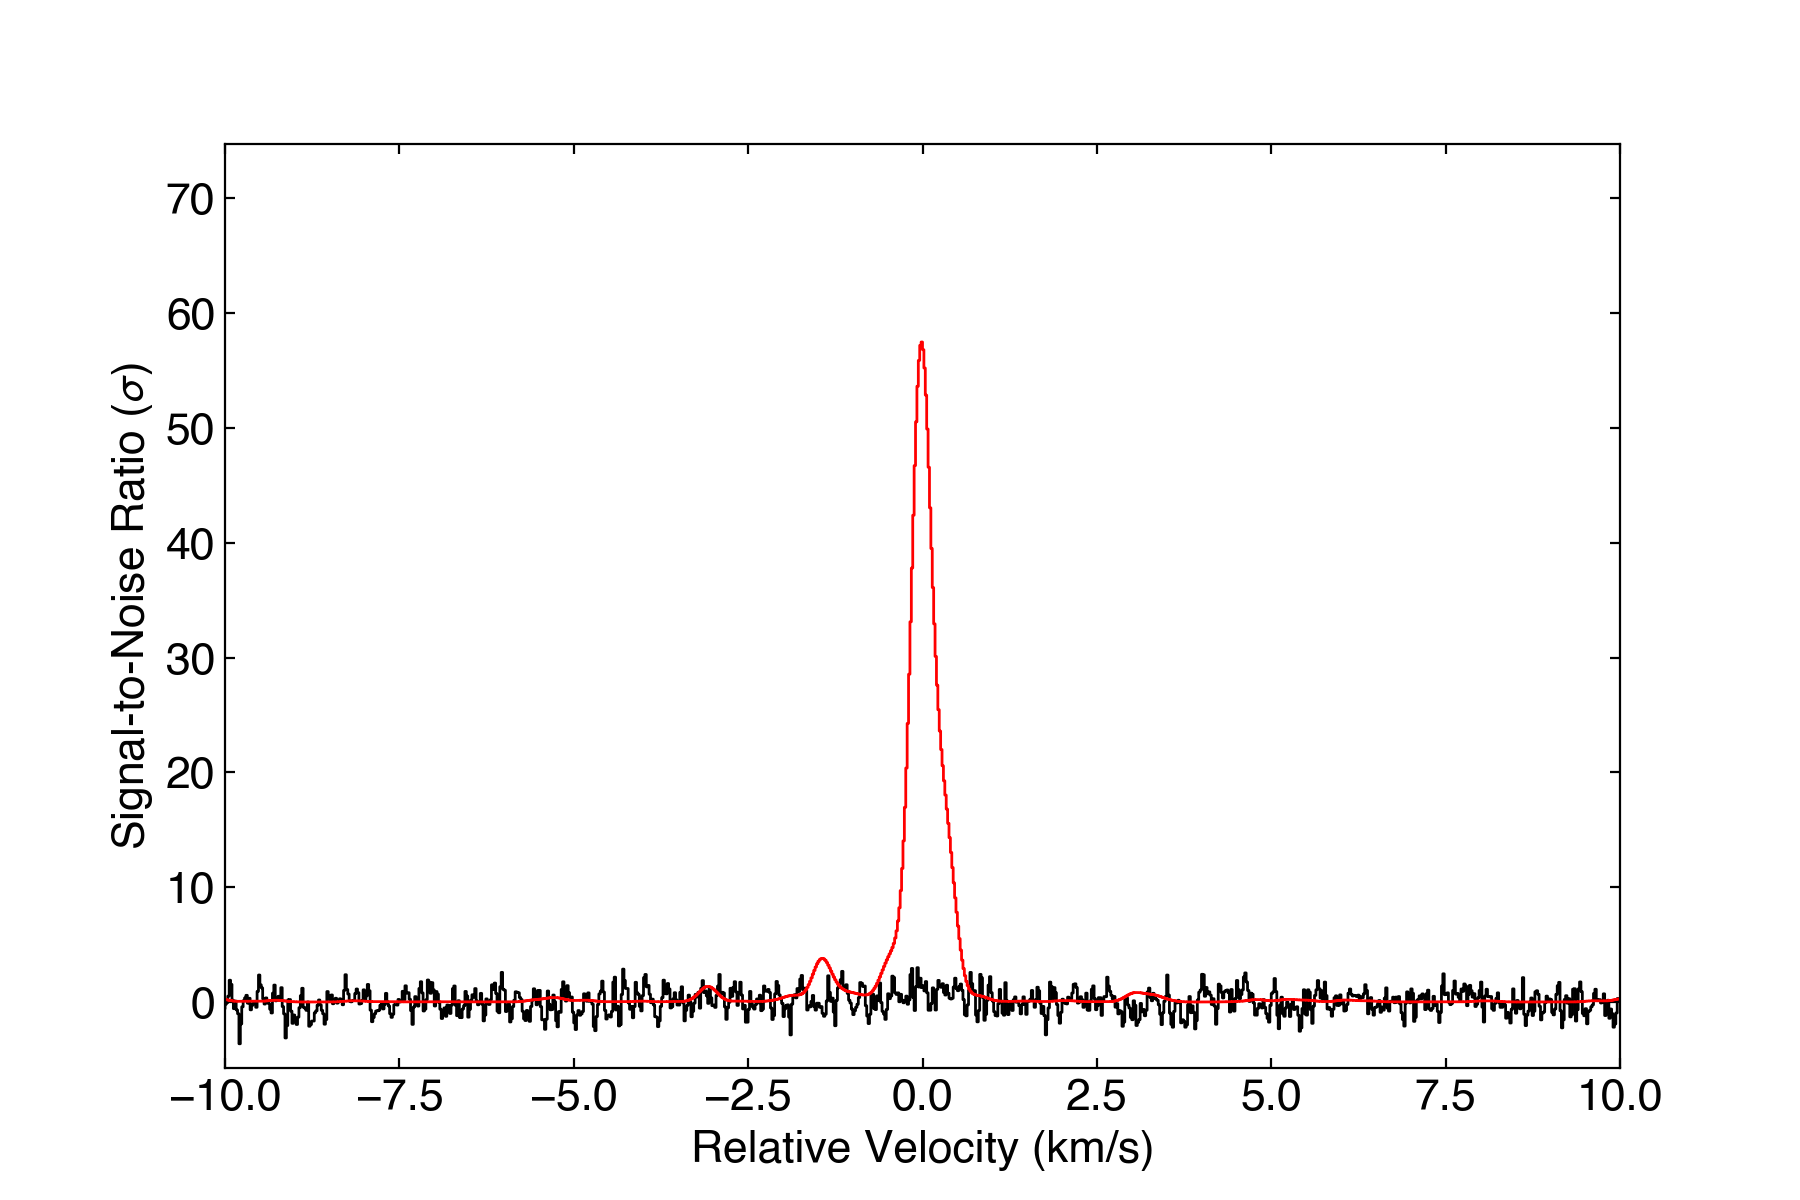

In [44]:
stack = velocity_stack(stack_params)
stack_plot_params = {'xlimits' : [-10,10]}
plot_stack(stack,params=stack_plot_params)

We can do a matched filter analysis using the `matched_filter` function.  It is not yet as elegant as the others, and takes three arguments in order from a stacked `Spectrum` object.  First, it takes the velocity spectrum, next, it takes the spectrum in SNR space, and third, it needs to know what part of the stacked simulation to use as the filter.  In this case, we use the central -2 to +2 km/s of the stacked spectrum as the filter.  Best to treat this as a black box.

You can plot the result of matched filter analysis using the `plot_mf` command, which takes as its only required argument a `Spectrum` object returned by `matched_filter`.  Like the others, there are many options here that you can pass as an optional dictionary, but it produces the plot you want with the defaults, so don't bother.

<IPython.core.display.Javascript object>


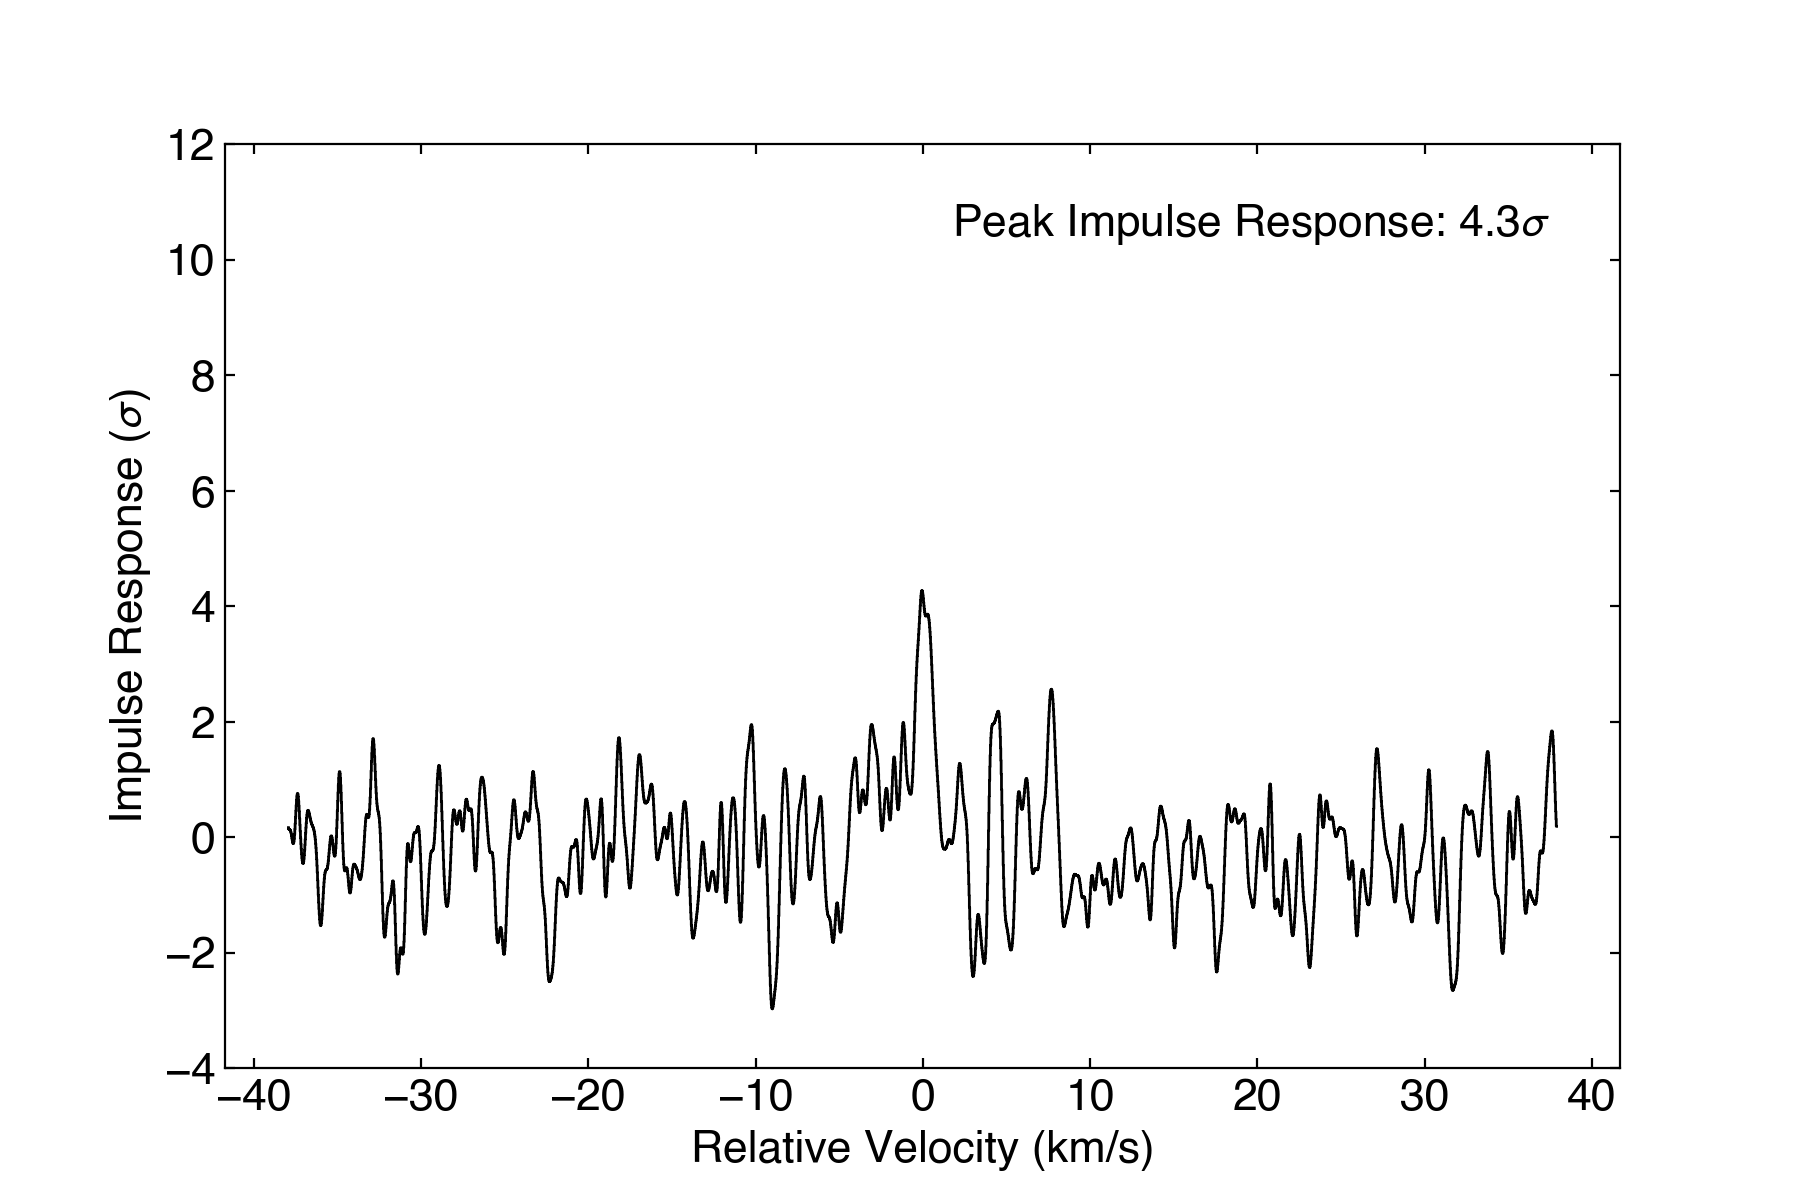

In [45]:
mf = matched_filter(
    stack.velocity,
    stack.snr,
    stack.int_sim[find_nearest(stack.velocity,-2):find_nearest(stack.velocity,2)]
)
plot_mf(mf)

That's it, you're done!